<h1 id="title">Predicting Motor Vehicle Accident Severity in Seattle, Washington by Oversampling Minority Classes to Achieve Balanced Training Data<\h1>

In [1]:
# Import packages and modules.
import io
import itertools
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import sklearn
import sys
import timeit
import warnings
from matplotlib.ticker import NullFormatter
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
from timeit import default_timer
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

In [3]:
# Define the starting time for this notebook. 
notebook_start_time = default_timer()

In [4]:
# This function computes the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def elapsed_time(start_time = notebook_start_time):
    return default_timer() - start_time   

In [5]:
# This function prints the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def print_elapsed_time(start_time = notebook_start_time):
    print("Elapsed time is", elapsed_time(start_time), "seconds.")
    return None

In [6]:
# Create a list of display options.
list_of_display_options_fully_qualified_names = str(\
"pd.options.display.chop_threshold, pd.options.display.float_format, pd.options.display.max_info_columns, pd.options.display.notebook_repr_html, \
pd.options.display.colheader_justify, pd.options.display.html, pd.options.display.max_info_rows, pd.options.display.pprint_nest_depth, \
pd.options.display.column_space, pd.options.display.large_repr, pd.options.display.max_rows, pd.options.display.precision, \
pd.options.display.date_dayfirst, pd.options.display.latex, pd.options.display.max_seq_items, pd.options.display.show_dimensions, \
pd.options.display.date_yearfirst, pd.options.display.max_categories, pd.options.display.memory_usage, pd.options.display.unicode, \
pd.options.display.encoding, pd.options.display.max_columns, pd.options.display.min_rows, pd.options.display.width, \
pd.options.display.expand_frame_repr, pd.options.display.max_colwidth, pd.options.display.multi_sparse").split(sep=', ')

# Initialize an empty list to store all the short names for display options.
list_of_display_options_short_names = list()
# For each fully qualified option name,
# get the option's short name and add it to the list of short names.
for fully_qualified_option_name in list_of_display_options_fully_qualified_names:
    # Get short option name.
    short_option_name = fully_qualified_option_name.split(sep='.')[-1]
    
    # Add short option name to list of display option short names.
    list_of_display_options_short_names.append(short_option_name)

# Define dictionary of display option settings.
dict_of_display_option_settings_short_names=\
{"max_info_columns": 1000,\
"colheader_justify": "right",\
"max_info_rows": 1000000,\
"column_space": 1000,\
"max_rows": 1000000,\
"precision": 9,\
"max_seq_items": 1000000000000,\
"show_dimensions": True,\
"max_categories": 100,\
"memory_usage": True,\
"max_columns": 1000,\
"max_colwidth": 1000,\
"float_format": lambda x: '%.9f' % x}

# Set pandas display options using dictionary of short names,
# and display the options/value pairs.
print("Setting display options...")
for key in list(dict_of_display_option_settings_short_names.keys()):
    # Set display option.
    pd.set_option(key, dict_of_display_option_settings_short_names[key])
    # Print display option name and value.
    print(key, ": ", pd.get_option(key), sep='')

Setting display options...
max_info_columns: 1000
colheader_justify: right
max_info_rows: 1000000
column_space: 1000
max_rows: 1000000
precision: 9
max_seq_items: 1000000000000
show_dimensions: True
max_categories: 100
memory_usage: True
max_columns: 1000
max_colwidth: 1000
float_format: <function <lambda> at 0x7fb4d2089310>


In [7]:
# Set seed for random number generator.
# seed = np.int(os.times()[4]) # Use this line for better pseudo-random behavior.
seed = 42
print(seed)

42


In [8]:
# Attribute Information URL: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
# Read the Collisions Data CSV file and store it as a DataFrame.
# url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv" # HTTPError at 202009151050, using local copy of .csv instead.
# print(os.listdir("..")) # Print list of contents of current working directory.
local_path_to_csv = '~/IBM Data Science Professional Certificate Course/Course 9 - Applied Data Science Capstone/projects/Collisions.csv'
df=pd.read_csv(local_path_to_csv, low_memory=False)

In [9]:
# View the first few rows of the collisions DataFrame.
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757054,47.609407946,1,328476,329976,EA08706,Matched,Block,nan,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/01/22 00:00:00+00,1/22/2020 3:21:00 PM,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,nan,NaN,11,From same direction - both going straight - both moving - sideswipe,0,0,N
1,-122.319560827,47.662220664,2,328142,329642,EA06882,Matched,Block,nan,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020/01/07 00:00:00+00,1/7/2020 8:00:00 AM,Mid-Block (not related to intersection),15.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",NaN,N,Clear,Dry,Daylight,NaN,nan,NaN,32,One parked--one moving,0,0,Y
2,-122.327524508,47.604393273,3,20700,20700,1181833,Unmatched,Block,nan,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/30 00:00:00+00,1/30/2004,Mid-Block (but intersection related),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4030032.000000000,NaN,NaN,NaN,0,0,N
3,-122.327524934,47.708621579,4,332126,333626,M16001640,Unmatched,Block,nan,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NORTHGATE DR,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016/01/23 00:00:00+00,1/23/2016,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N
4,-122.292120049,47.559009080,5,328238,329738,3857118,Unmatched,Block,nan,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND S EDMUNDS ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020/01/26 00:00:00+00,1/26/2020,Mid-Block (not related to intersection),28.000000000,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

In [11]:
print_elapsed_time(notebook_start_time)

Elapsed time is 10.81538292800542 seconds.


<h2 id="data_wrangling">Data Wrangling</h2>

Steps for working with missing data:
<ol>
    <li>Identify missing data.</li>
    <li>Deal with missing data.</li>
    <li>Correct data format.</li>
</ol>

<h3 id="identifying_missing_data">Identifying Missing Data</h3>

The metadata document that accompanied the data set indicates that certain columns have "sentinel" values
that indicate an unknown or missing value. Each of these missing values will first be converted into NaN.
Subsequently, the NaN values will be dropped from the DataFrame.

In [12]:
# If any row of the collisions DataFrame contains a sentinel value representing "unknown",
# then replace it with NaN. 
# Sentinels for "unknown" are listed in the metadata document that accompanies the dataset.
df_unknowns_converted_to_nan = df.replace(to_replace=\
{"EXCEPTRSNCODE": " ",\
 "EXCEPTRSNDESC": "Not Enough Information, or Insufficient Location Information",\
 "SEVERITYCODE": "0",\
 "SEVERITYDESC": "Unknown",\
 "JUNCTIONTYPE": "Unknown",\
 "WEATHER": "Unknown",\
 "ROADCOND": "Unknown",\
 "LIGHTCOND": "Unknown",\
 "SDOT_COLCODE": float(0),\
 "SDOT_COLDESC": "NOT ENOUGH INFORMATION / NOT APPLICABLE",\
 "ST_COLCODE": " ",\
 "ST_COLDESC": "Not stated"},\
value=np.nan, inplace=False, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace={"ST_COLCODE": "0", }, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

In [13]:
print_elapsed_time(notebook_start_time)

Elapsed time is 17.784873913042247 seconds.


<h3 id="deal_with_missing_data">Deal with Missing Data</h3>

<ol>
    <li>Drop the Data
        <ol>
            <li>Drop entire row.</li>
            <li>Drop entire column.</li>
        </ol>
    </li>
    <li>Replace the Data
        <ol>
            <li>Replace data by mean.</li>
            <li>Replace data by frequency.</li>
            <li>Replace data based on other functions.</li>
        </ol>
    </li>
        
</ol>

Whole columns should be dropped only if most entries in the column are empty.

In [14]:
print(list(df.columns))

['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [15]:
# Drop any column from the collisions DataFrame if it satisfies at least one of the following conditions:
# 1) more than 15% of the column's data is NaN;
# 2) the column only contains unique identification keys, or information not useful for model building;
# 3) the column's data is categorical but does not fit into a small (< 15) number of categories;
# 4) information in the column is redundant because it is already represented by another column;
# 5) it is not clear how to interpret the column's data.
list_of_columns_to_drop = ["ADDRTYPE",\
                           "STATUS",\
                           "OBJECTID",\
                           "INCKEY",\
                           "COLDETKEY",\
                           "REPORTNO",\
                           "INTKEY",\
                           "LOCATION",\
                           "EXCEPTRSNCODE",\
                           "EXCEPTRSNDESC",\
                           "SEVERITYDESC",\
                           "PERSONCOUNT",\
                           "INCDATE",\
                           "INCDTTM",\
                           "JUNCTIONTYPE",\
                           "SDOT_COLCODE",\
                           "SDOT_COLDESC",\
                           "INATTENTIONIND",\
                           "UNDERINFL",\
                           "PEDROWNOTGRNT",\
                           "SDOTCOLNUM",\
                           "SPEEDING",\
                           "ST_COLCODE",\
                           "ST_COLDESC",\
                           "SEGLANEKEY",\
                           "CROSSWALKKEY",\
                           "HITPARKEDCAR"]

In [16]:
# Drop the selected columns from the DataFrame after converting unknowns to NaN.
# Store the result in a new DataFrame.
df_drop_columns = df_unknowns_converted_to_nan.drop(columns=list_of_columns_to_drop, inplace=False)

In [17]:
# Drop any row that contains at least one NaN.
df_drop_columns_and_rows = df_drop_columns.dropna(axis="index", how="any", thresh=None, subset=None, inplace=False)

In [18]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.920650191023014 seconds.


<h3 id="correct_data_format">Correct Data Format</h3>

Ensure that each data type is appropriate for the corresponding feature.
Cast columns of type "object" as type "category", but leave all other column types unaltered.

In [19]:
# Create new DataFrame to store converted data types.
df_converted = pd.DataFrame()

for column in list(df_drop_columns_and_rows.columns):
    if (df_drop_columns_and_rows[column].dtype in [np.dtype('object')]):
        df_converted[column] = df_drop_columns_and_rows[column].astype('category')
    # Copy all other columns to new DataFrame without changing their types.
    else:
        df_converted[column] = df_drop_columns_and_rows[column]

In [20]:
# Create DataFrame of categorical or integer columns, inclusive.
df_categorical = df_converted.select_dtypes(include=["category", "integer"])

In [21]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.545803862041794 seconds.


<h2 id="feature_selection">Feature selection</h2>

#### Features before One-Hot Encoding

In [22]:
df_categorical.head()

,SEVERITYCODE,COLLISIONTYPE,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND
0,1,Sideswipe,0,0,2,0,0,0,Raining,Wet,Dark - Street Lights On
1,1,Parked Car,0,0,2,0,0,0,Clear,Dry,Daylight
5,1,Rear Ended,0,0,2,0,0,0,Clear,Dry,Daylight
6,1,Other,0,0,1,0,0,0,Clear,Wet,Daylight
8,1,Sideswipe,0,0,2,0,0,0,Overcast,Dry,Daylight


In [23]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   SEVERITYCODE     171872 non-null  category
 1   COLLISIONTYPE    171872 non-null  category
 2   PEDCOUNT         171872 non-null  int64   
 3   PEDCYLCOUNT      171872 non-null  int64   
 4   VEHCOUNT         171872 non-null  int64   
 5   INJURIES         171872 non-null  int64   
 6   SERIOUSINJURIES  171872 non-null  int64   
 7   FATALITIES       171872 non-null  int64   
 8   WEATHER          171872 non-null  category
 9   ROADCOND         171872 non-null  category
 10  LIGHTCOND        171872 non-null  category
dtypes: category(5), int64(6)
memory usage: 10.0 MB


In [24]:
print_elapsed_time(notebook_start_time)

Elapsed time is 20.035435099038295 seconds.


<h2 id="imbalanced_data">Dealing with Imbalanced Data</h2>

Because the data is imbalanced, we split the DataFrame into four DataFrames, one for each value of the SEVERITYCODE feature.

In [25]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657943120
2    0.323036911
2b   0.017111571
3    0.001908397
Name: SEVERITYCODE, Length: 4, dtype: float64


In [26]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
2      55521
2b      2941
3        328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [27]:
df_class_1 = df_categorical[df_categorical['SEVERITYCODE'] == '1']
df_class_2 = df_categorical[df_categorical['SEVERITYCODE'] == '2']
df_class_2b = df_categorical[df_categorical['SEVERITYCODE'] == '2b']
df_class_3 = df_categorical[df_categorical['SEVERITYCODE'] == '3']

In [28]:
print("SEVERITYCODE relative frequencies:")
print(df_class_1["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
3          0
2b         0
2          0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [29]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2     55521
3         0
2b        0
1         0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [30]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2b["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2b    2941
3        0
2        0
1        0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [31]:
print("SEVERITYCODE relative frequencies:")
print(df_class_3["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b      0
2       0
1       0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [32]:
# Store and print the size of the all classes.
class_1_size = len(df_class_1)
class_2_size = len(df_class_2)
class_2b_size = len(df_class_2b)
class_3_size = len(df_class_3)
print('class_1_size =', class_1_size)
print('class_2_size =', class_2_size)
print('class_2b_size =', class_2b_size)
print('class_3_size =', class_3_size)
print()
# Store and print the size of the minority class.
minority_class_size = len(df_class_3)
print('minority_class_size =', minority_class_size)

class_1_size = 113082
class_2_size = 55521
class_2b_size = 2941
class_3_size = 328

minority_class_size = 328


In [33]:
print_elapsed_time(notebook_start_time)

Elapsed time is 21.045279166079126 seconds.


<h2 id='sample_size_class_3'>Sample all Classes Equally to Create a Balanced Training Set<\h2>

In [34]:
# This parameter determines what fraction of the minority class's data are reserved for testing.
test_size_ratio = .25

# Using train/test splits, set aside part of the data for testing.
df_class_1_train_pre_sampling, df_class_1_test = train_test_split(df_class_1, test_size=test_size_ratio, random_state=seed)
df_class_2_train_pre_sampling, df_class_2_test = train_test_split(df_class_2, test_size=test_size_ratio, random_state=seed)
df_class_2b_train_pre_sampling, df_class_2b_test = train_test_split(df_class_2b, test_size=test_size_ratio, random_state=seed)
df_class_3_train_pre_sampling, df_class_3_test = train_test_split(df_class_3, test_size=test_size_ratio, random_state=seed)

In [35]:
# Build a balanced training set by sampling the pre_sampling training data equally:

# Set a sampling parameter to control the amount of oversampling for the minority class.
# Oversampling requires this parameter to be greater than 1.
# If this parameter is less than or equal to 1, then oversampling will not occur.
sampling_ratio = 2

# Set the replace parameter of the sample method based on the sampling ratio.
# If the sampling_ratio > 1, sample with replacement.
# Otherwise, sample without replacement.
sample_with_replacement = bool(sampling_ratio > 1)
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 3 with replacement: %s' % (sample_with_replacement))

# Sample the minority class's training set based on the sampling parameter and store the sample for later concatenation.
df_class_3_train = df_class_3_train_pre_sampling.sample(frac=sampling_ratio, replace=sample_with_replacement, axis='index', random_state=seed)

# Store the size of the minority class's training set.
class_3_train_size = df_class_3_train.shape[0]

# Take samples of the other classes' training data, where the sample size taken is equal to the size of the minority class's training set.
# If the sample size to be taken exceeds the number of samples in the class's training data, sample with replacement.

# Sampling for class 2b.
sample_with_replacement = bool(class_3_train_size > df_class_2b_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 2b with replacement: %s' % (sample_with_replacement))
df_class_2b_train = df_class_2b_train_pre_sampling.sample(n=class_3_train_size, replace=sample_with_replacement, axis='index', random_state=seed)

# Sampling for class 2.
sample_with_replacement = bool(class_3_train_size > df_class_2_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 2 with replacement: %s' % (sample_with_replacement))
df_class_2_train = df_class_2_train_pre_sampling.sample(n=class_3_train_size, replace=sample_with_replacement, axis='index', random_state=seed)

# Sampling for class 1.
sample_with_replacement = bool(class_3_train_size > df_class_1_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 1 with replacement: %s' % (sample_with_replacement))
df_class_1_train = df_class_1_train_pre_sampling.sample(n=class_3_train_size, replace=sample_with_replacement, axis='index', random_state=seed)

Sample class 3 with replacement: True
Sample class 2b with replacement: False
Sample class 2 with replacement: False
Sample class 1 with replacement: False


In [36]:
# Make a balanced, unshuffled training set by concatenating the equal sized samples of the training sets for each class.
df_train_balanced_not_shuffled = pd.concat([df_class_1_train, df_class_2_train, df_class_2b_train, df_class_3_train], axis='index')

# Make a not necessarily balanced testing set by concatenating the testing sets for each class.
df_test_not_shuffled = pd.concat([df_class_1_test, df_class_2_test, df_class_2b_test, df_class_3_test], axis='index')

In [37]:
# Shuffle the training set and store it for tuning hyper-parameters and for cross-validation.
df_train = shuffle(df_train_balanced_not_shuffled, random_state=seed)

# Shuffle the unbalanced DataFrame and store it for validation and for comparing the models.
df_test = shuffle(df_test_not_shuffled, random_state=seed)

In [38]:
# Verify the training DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_train["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     492
2b    492
2     492
1     492
Name: SEVERITYCODE, Length: 4, dtype: int64


In [39]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_train["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
3    0.250000000
2b   0.250000000
2    0.250000000
1    0.250000000
Name: SEVERITYCODE, Length: 4, dtype: float64


Let's define a feature set represented by the DataFrame X. 

In [40]:
X = df_train.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1968 entries, 112710 to 27955
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   COLLISIONTYPE  1968 non-null   category
 1   PEDCOUNT       1968 non-null   int64   
 2   PEDCYLCOUNT    1968 non-null   int64   
 3   VEHCOUNT       1968 non-null   int64   
 4   WEATHER        1968 non-null   category
 5   ROADCOND       1968 non-null   category
 6   LIGHTCOND      1968 non-null   category
dtypes: category(4), int64(3)
memory usage: 70.7 KB


We also define the data for the target variable, SEVERITYCODE, by the array y:

In [42]:
y = df_train["SEVERITYCODE"].to_numpy()

In [43]:
print_elapsed_time(notebook_start_time)

Elapsed time is 22.414702420006506 seconds.


## Transform the Data 

We normalize the data by transforming it so that it is compatible
with the machine learning estimators we use in this notebook.
We use special care with sparse matrix data so as to not destroy the
structure.

In [44]:
# Create a OneHotEncoder and fit it to the features.
# The fit is performed on the data set before the any test/train splits.
# The data will be encoded as a sparse matrix, the default behavior.
start_time = default_timer()
print("Fitting OneHotEncoder to training data...")
encoder = OneHotEncoder(sparse=True, handle_unknown='error')
encoder.fit(df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False))
#encoder.fit(X)
X = encoder.transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")
# Display the categories of the encoder.
print(encoder.get_feature_names())

Fitting OneHotEncoder to training data...
Completed in 0.20098556007724255 seconds.
['x0_Angles' 'x0_Cycles' 'x0_Head On' 'x0_Left Turn' 'x0_Other'
 'x0_Parked Car' 'x0_Pedestrian' 'x0_Rear Ended' 'x0_Right Turn'
 'x0_Sideswipe' 'x1_0' 'x1_1' 'x1_2' 'x1_3' 'x1_4' 'x1_5' 'x1_6' 'x2_0'
 'x2_1' 'x2_2' 'x3_0' 'x3_1' 'x3_2' 'x3_3' 'x3_4' 'x3_5' 'x3_6' 'x3_7'
 'x3_8' 'x3_9' 'x3_10' 'x3_11' 'x3_12' 'x3_13' 'x3_14' 'x3_15'
 'x4_Blowing Sand/Dirt' 'x4_Clear' 'x4_Fog/Smog/Smoke' 'x4_Other'
 'x4_Overcast' 'x4_Partly Cloudy' 'x4_Raining' 'x4_Severe Crosswind'
 'x4_Sleet/Hail/Freezing Rain' 'x4_Snowing' 'x5_Dry' 'x5_Ice' 'x5_Oil'
 'x5_Other' 'x5_Sand/Mud/Dirt' 'x5_Snow/Slush' 'x5_Standing Water'
 'x5_Wet' 'x6_Dark - No Street Lights' 'x6_Dark - Street Lights Off'
 'x6_Dark - Street Lights On' 'x6_Dark - Unknown Lighting' 'x6_Dawn'
 'x6_Daylight' 'x6_Dusk' 'x6_Other']


In [45]:
type(X)

scipy.sparse.csr.csr_matrix

In [46]:
X.shape

(1968, 62)

In [47]:
y.shape

(1968,)

In [48]:
print_elapsed_time(notebook_start_time)

Elapsed time is 23.081727219047025 seconds.


<h2 id="logistic_regression">Building a Logistic Regression Model<\h2>

In [49]:
t0 = default_timer()
#kfold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
number_of_folds = 10
logistic_regression_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LogisticRegression(solver='saga', multi_class='auto', penalty='l1', max_iter=100, verbose=10, n_jobs=-1, random_state=seed), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
logistic_regression_scores = cross_validate(logistic_regression_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Logistic regression score keys:", sorted(logistic_regression_scores.keys()))
print('Logistic Regression classifiers constructed in %f seconds.' % elapsed_time(t0))

Logistic regression score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Logistic Regression classifiers constructed in 8.193375 seconds.


In [50]:
print_elapsed_time(notebook_start_time)

Elapsed time is 31.457786826998927 seconds.


<h2 id="support_vector_machine">Building a Support Vector Machine<\h2>

In [51]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
linear_svc_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LinearSVC(penalty='l1', dual=False, random_state=seed, max_iter=100), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
linear_svc_scores = cross_validate(linear_svc_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Support Vector Machine score keys:", sorted(linear_svc_scores.keys()))
print('Support Vector Machine classifiers constructed in %f seconds.' % elapsed_time(t0))

Support Vector Machine score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Support Vector Machine classifiers constructed in 0.862820 seconds.


In [52]:
print_elapsed_time(notebook_start_time)

Elapsed time is 32.472134787007235 seconds.


<h2 id="knn_classifier">Building a k-Nearsest Neighbors Classifier<\h2>

In [53]:
t0 = default_timer()
number_of_folds = 10

# Set maximum number of neighbors based on number of samples and number of folds to prevent errors.
maximum_number_of_neighbors = min(200, np.int((X.shape[0] * (1 - 1 / number_of_folds))) - 1) # Take the smaller of the two parameters for min().
k_neighbors_pipeline = make_pipeline(\
    StandardScaler(with_mean=False),\
    KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=-1, p=1, weights='distance'), verbose=True)

# Use only odd numbers of neighbors to avoid ties.
grid_parameters = {'kneighborsclassifier__n_neighbors': range(3, maximum_number_of_neighbors, 2)}
scoring = ['recall_weighted']
grid_search_cv = GridSearchCV(k_neighbors_pipeline, param_grid=grid_parameters,\
                              scoring=scoring, \
                              n_jobs=-1, refit='recall_weighted', cv=number_of_folds, verbose=50, pre_dispatch=2**10, error_score='raise',\
                              return_train_score=False)

grid_search_cv.fit(X, y)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1, p=1,
                                                             weights='distance'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': range(3, 200, 2)},
             pre_dispatch=1024, refit='recall_weighted',
             scoring=['recall_weighted'], verbose=50)

In [54]:
print('Completed grid search in %f seconds' % (elapsed_time(t0)))

Completed grid search in 83.517632 seconds


In [55]:
# Store best KNeighborsClassifier from GridSearchCV and print its parameters.
k_neighbors_clf = grid_search_cv.best_estimator_
print('Best KNeighborsClassifier parameters:')
for key in k_neighbors_clf.get_params().keys():
    print(key, ':', k_neighbors_clf.get_params()[key])

Best KNeighborsClassifier parameters:
memory : None
steps : [('standardscaler', StandardScaler(with_mean=False)), ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=75, p=1, weights='distance'))]
verbose : True
standardscaler : StandardScaler(with_mean=False)
kneighborsclassifier : KNeighborsClassifier(n_jobs=-1, n_neighbors=75, p=1, weights='distance')
standardscaler__copy : True
standardscaler__with_mean : False
standardscaler__with_std : True
kneighborsclassifier__algorithm : auto
kneighborsclassifier__leaf_size : 30
kneighborsclassifier__metric : minkowski
kneighborsclassifier__metric_params : None
kneighborsclassifier__n_jobs : -1
kneighborsclassifier__n_neighbors : 75
kneighborsclassifier__p : 1
kneighborsclassifier__weights : distance


In [56]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
k_neighbors_scores = cross_validate(k_neighbors_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("k-Neighbors score keys:", sorted(k_neighbors_scores.keys()))
print('k-Neighbors Classifiers constructed in %f seconds.' % elapsed_time(t0))

k-Neighbors score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
k-Neighbors Classifiers constructed in 1.599156 seconds.


In [57]:
print_elapsed_time(notebook_start_time)

Elapsed time is 118.03366368706338 seconds.


## Test the Models and Compare their Performance

In [58]:
# Set starting time for reports and graphics.
t0 = default_timer()

In [59]:
#df_categorical.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42970 entries, 94183 to 109788
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   SEVERITYCODE     42970 non-null  category
 1   COLLISIONTYPE    42970 non-null  category
 2   PEDCOUNT         42970 non-null  int64   
 3   PEDCYLCOUNT      42970 non-null  int64   
 4   VEHCOUNT         42970 non-null  int64   
 5   INJURIES         42970 non-null  int64   
 6   SERIOUSINJURIES  42970 non-null  int64   
 7   FATALITIES       42970 non-null  int64   
 8   WEATHER          42970 non-null  category
 9   ROADCOND         42970 non-null  category
 10  LIGHTCOND        42970 non-null  category
dtypes: category(5), int64(6)
memory usage: 2.5 MB


In [60]:
# Print the relative frequencies for the validation DataFrame.
print("SEVERITYCODE relative frequencies:")
print(df_test["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     28271
2     13881
2b      736
3        82
Name: SEVERITYCODE, Length: 4, dtype: int64


In [61]:
# Print the relative frequencies for the validation DataFrame.
print("SEVERITYCODE relative frequencies:")
print(df_test["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657924133
2    0.323039330
2b   0.017128229
3    0.001908308
Name: SEVERITYCODE, Length: 4, dtype: float64


In [62]:
# Encode the data using the OneHotEncoder fitted before the models were created.
start_time = default_timer()
# print("Transforming full data set's feature set using OneHotEncoder...")
# X = df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)
# X = encoder.transform(X)
print('Transforming features using OneHotEncoder...')
X_test = df_test.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)
X_test = encoder.transform(X_test)
print("Encoding completed in", elapsed_time(start_time), "seconds.")

Transforming features using OneHotEncoder...
Encoding completed in 0.17493897106032819 seconds.


In [63]:
y_test = df_test['SEVERITYCODE'].to_numpy()

In [64]:
X_test.shape

(42970, 62)

In [65]:
y_test.shape

(42970,)

In [66]:
print_elapsed_time(notebook_start_time)

Elapsed time is 119.1651371930493 seconds.


In [67]:
# Report statistics of the models built for each fold of the cross-validation.
print('Logistic Regression Cross-validation Scores:')
print()
for key in sorted(logistic_regression_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(logistic_regression_scores[key]), np.std(logistic_regression_scores[key])), sep='')
        print('%s :%s' % (key, logistic_regression_scores[key]), sep='')
        print()

Logistic Regression Cross-validation Scores:

fit_time: mean = 0.882120, std = 0.070781
fit_time :[0.90744877 0.87260008 0.93846631 0.84151483 0.77360582 0.95480943
 0.97748375 0.85010719 0.9409585  0.76420808]

score_time: mean = 0.072260, std = 0.022747
score_time :[0.08052015 0.09559178 0.0527091  0.05449367 0.12246084 0.04713678
 0.08261776 0.07445955 0.04955673 0.06305671]

test_f1_macro: mean = 0.476487, std = 0.033626
test_f1_macro :[0.54288272 0.47436417 0.45519387 0.45789503 0.48995953 0.4734253
 0.40350655 0.49362224 0.49263107 0.48139085]

test_f1_weighted: mean = 0.476521, std = 0.033676
test_f1_weighted :[0.54293094 0.47383628 0.45604543 0.45862463 0.49043826 0.47364575
 0.40282018 0.49284705 0.49263107 0.48139085]

test_neg_log_loss: mean = -1.149619, std = 0.029276
test_neg_log_loss :[-1.12871515 -1.15097289 -1.1391533  -1.18731262 -1.09005152 -1.15516938
 -1.17927152 -1.18224112 -1.11983386 -1.16347328]

test_precision_macro: mean = 0.484709, std = 0.030836
test_precisi

Logistic Regression Model 1 of 10:

              precision    recall  f1-score   support

           1   0.850952  0.491741  0.623296     28271
           2   0.410157  0.478856  0.441852     13881
          2b   0.034916  0.237772  0.060891       736
           3   0.007572  0.500000  0.014917        82

    accuracy                       0.483244     42970
   macro avg   0.325899  0.427092  0.285239     42970
weighted avg   0.692971  0.483244  0.553889     42970



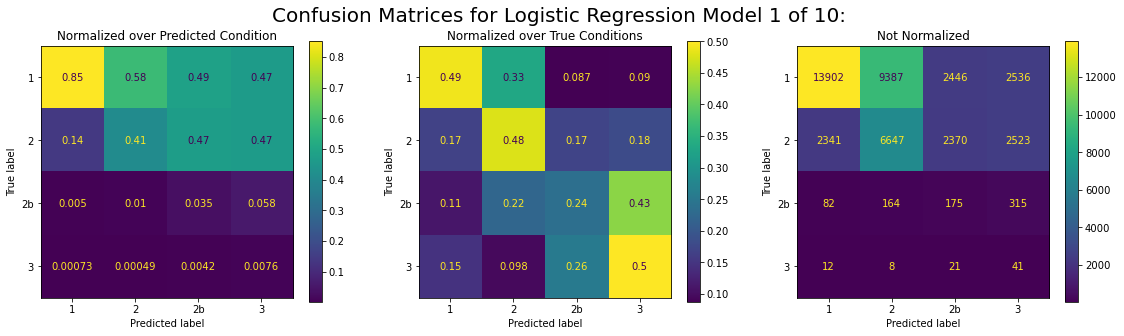

Logistic Regression Model 2 of 10:

              precision    recall  f1-score   support

           1   0.836789  0.508153  0.632320     28271
           2   0.408368  0.445789  0.426259     13881
          2b   0.034697  0.250000  0.060937       736
           3   0.007669  0.500000  0.015107        82

    accuracy                       0.483570     42970
   macro avg   0.321881  0.425986  0.283656     42970
weighted avg   0.683072  0.483570  0.554790     42970



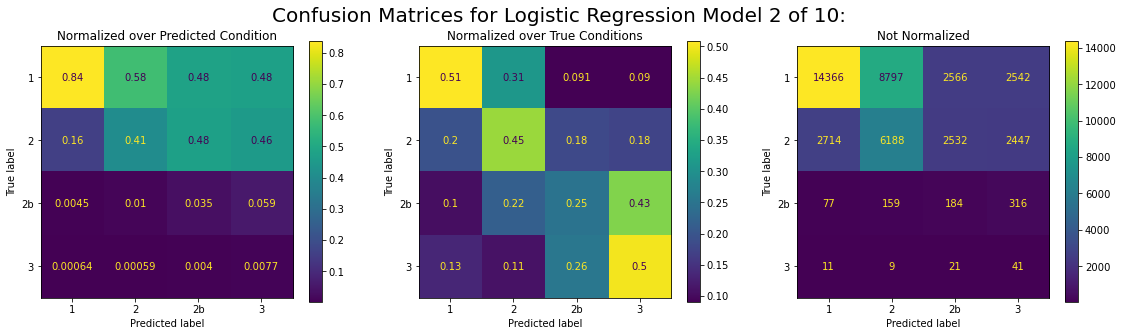

Logistic Regression Model 3 of 10:

              precision    recall  f1-score   support

           1   0.870664  0.458137  0.600366     28271
           2   0.405328  0.492112  0.444524     13881
          2b   0.032286  0.254076  0.057292       736
           3   0.007708  0.512195  0.015187        82

    accuracy                       0.465720     42970
   macro avg   0.328997  0.429130  0.279342     42970
weighted avg   0.704336  0.465720  0.539604     42970



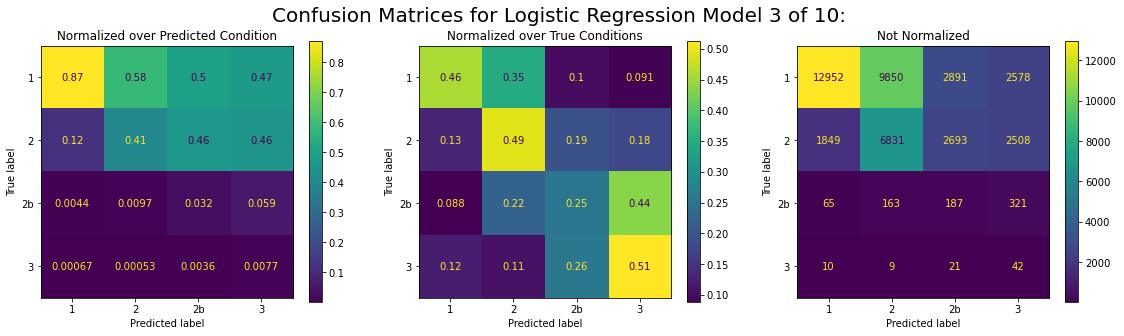

Logistic Regression Model 4 of 10:

              precision    recall  f1-score   support

           1   0.835483  0.510877  0.634049     28271
           2   0.410340  0.451697  0.430026     13881
          2b   0.033847  0.229620  0.058998       736
           3   0.007579  0.500000  0.014931        82

    accuracy                       0.486921     42970
   macro avg   0.321812  0.423048  0.284501     42970
weighted avg   0.682835  0.486921  0.557111     42970



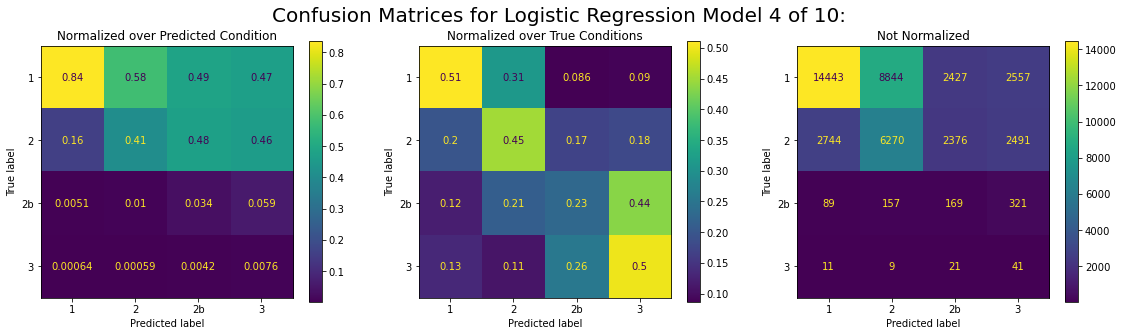

Logistic Regression Model 5 of 10:

              precision    recall  f1-score   support

           1   0.870145  0.463620  0.604929     28271
           2   0.403262  0.497010  0.445255     13881
          2b   0.034502  0.255435  0.060792       736
           3   0.007850  0.512195  0.015464        82

    accuracy                       0.470933     42970
   macro avg   0.328940  0.432065  0.281610     42970
weighted avg   0.703365  0.470933  0.542903     42970



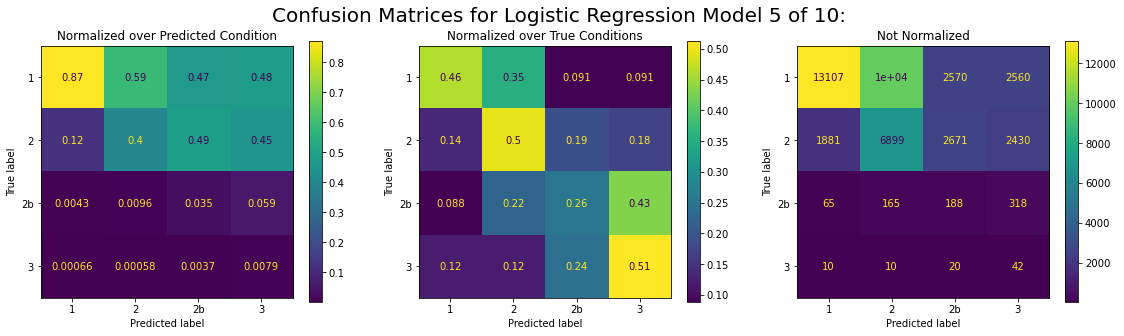

Logistic Regression Model 6 of 10:

              precision    recall  f1-score   support

           1   0.854315  0.487036  0.620393     28271
           2   0.408461  0.473669  0.438655     13881
          2b   0.034908  0.254076  0.061382       736
           3   0.007594  0.500000  0.014961        82

    accuracy                       0.478753     42970
   macro avg   0.326320  0.428695  0.283848     42970
weighted avg   0.694636  0.478753  0.550954     42970



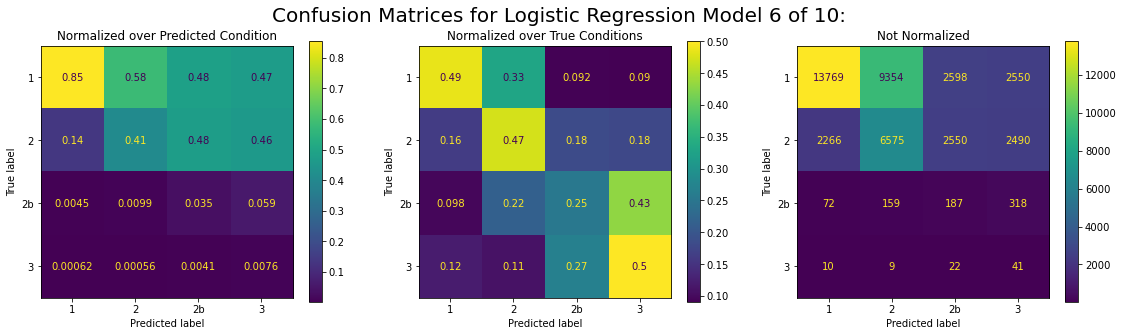

Logistic Regression Model 7 of 10:

              precision    recall  f1-score   support

           1   0.869066  0.465565  0.606320     28271
           2   0.408152  0.499892  0.449388     13881
          2b   0.036298  0.244565  0.063213       736
           3   0.007161  0.512195  0.014125        82

    accuracy                       0.472958     42970
   macro avg   0.330169  0.430554  0.283262     42970
weighted avg   0.704264  0.472958  0.545192     42970



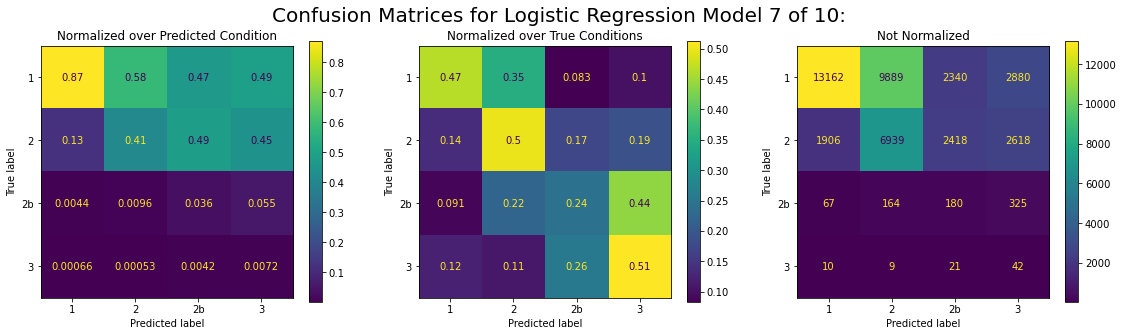

Logistic Regression Model 8 of 10:

              precision    recall  f1-score   support

           1   0.841992  0.482721  0.613638     28271
           2   0.409228  0.450472  0.428860     13881
          2b   0.029992  0.245924  0.053463       736
           3   0.007527  0.500000  0.014831        82

    accuracy                       0.468280     42970
   macro avg   0.322185  0.419779  0.277698     42970
weighted avg   0.686691  0.468280  0.543210     42970



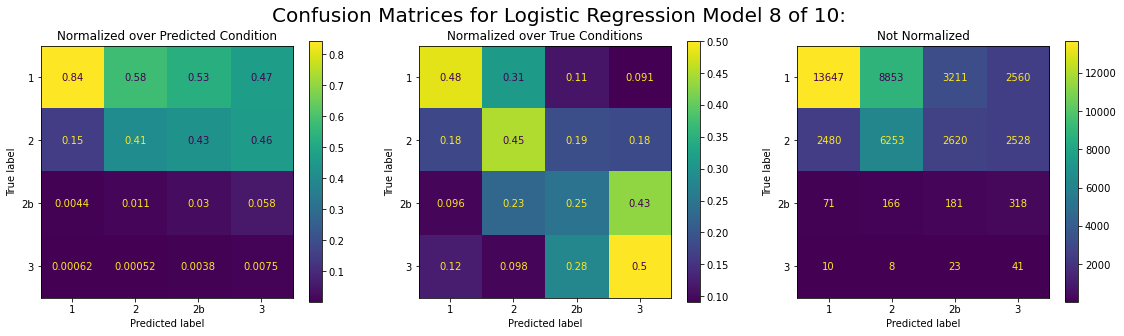

Logistic Regression Model 9 of 10:

              precision    recall  f1-score   support

           1   0.858244  0.480351  0.615957     28271
           2   0.406715  0.476479  0.438842     13881
          2b   0.034822  0.250000  0.061130       736
           3   0.007499  0.512195  0.014781        82

    accuracy                       0.475215     42970
   macro avg   0.326820  0.429756  0.282677     42970
weighted avg   0.696655  0.475215  0.548091     42970



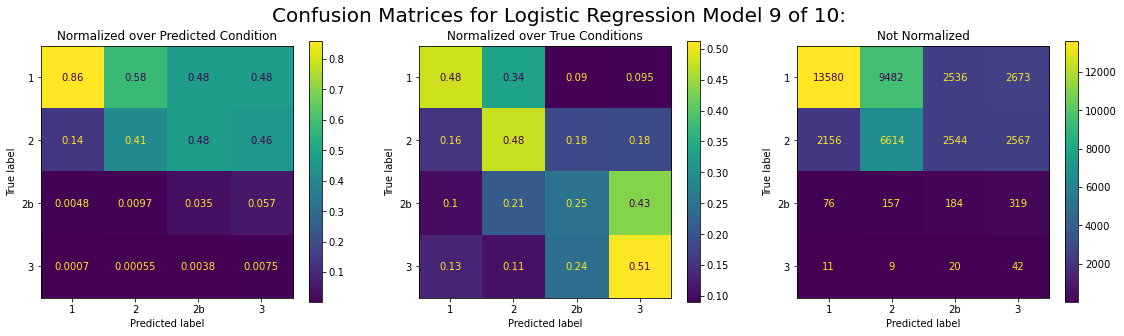

Logistic Regression Model 10 of 10:

              precision    recall  f1-score   support

           1   0.843668  0.500513  0.628289     28271
           2   0.408895  0.457028  0.431623     13881
          2b   0.035193  0.255435  0.061862       736
           3   0.008238  0.536585  0.016227        82

    accuracy                       0.482337     42970
   macro avg   0.323998  0.437390  0.284500     42970
weighted avg   0.687777  0.482337  0.553888     42970



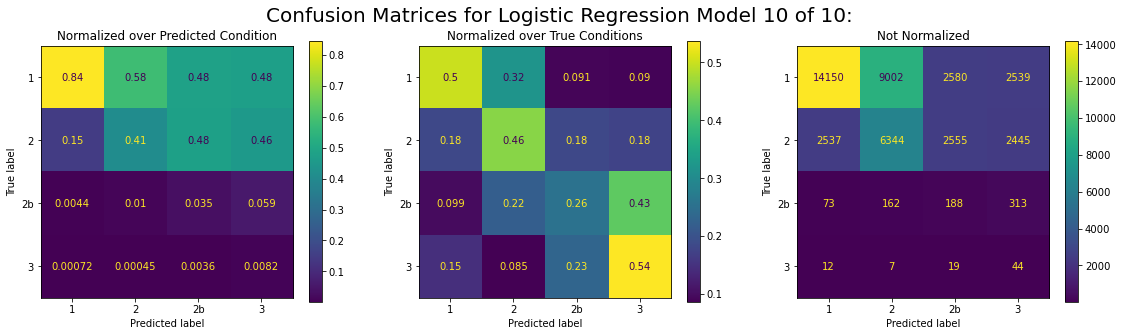

In [68]:
# For each logistic regression classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(logistic_regression_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, logistic_regression_clf in zip(range(len(logistic_regression_scores['estimator'])), logistic_regression_scores['estimator']):
    y_test_predicted = logistic_regression_clf.predict(X_test)
    print('Logistic Regression Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Logistic Regression Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [69]:
print_elapsed_time(notebook_start_time)

Elapsed time is 202.9672420800198 seconds.


In [70]:
# Report statistics of the models built for each fold of the cross-validation.
print('Support Vector Machine Cross-validation Scores:')
print()
for key in sorted(linear_svc_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(linear_svc_scores[key]), np.std(linear_svc_scores[key])), sep='')
        print('%s :%s' % (key, linear_svc_scores[key]), sep='')
        print()

Support Vector Machine Cross-validation Scores:

fit_time: mean = 0.106240, std = 0.022187
fit_time :[0.10673046 0.09489202 0.10069227 0.09992957 0.09428072 0.09496212
 0.09392428 0.08584166 0.12569165 0.16545701]

score_time: mean = 0.047286, std = 0.007438
score_time :[0.04406381 0.03815651 0.03999949 0.05239797 0.04281855 0.04749203
 0.04288173 0.05338478 0.06470847 0.04696131]

test_f1_macro: mean = 0.486417, std = 0.030629
test_f1_macro :[0.5445204  0.4896704  0.47234697 0.48493258 0.50690083 0.46380202
 0.4192015  0.49856809 0.50027632 0.48395281]

test_f1_weighted: mean = 0.486469, std = 0.030722
test_f1_weighted :[0.5447254  0.48925116 0.47311679 0.48558218 0.50724505 0.46395724
 0.41870295 0.49788316 0.50027632 0.48395281]

test_precision_macro: mean = 0.501175, std = 0.031396
test_precision_macro :[0.56800901 0.50473138 0.48218719 0.49890134 0.5177877  0.47245656
 0.44607201 0.52512244 0.51016532 0.48632138]

test_precision_weighted: mean = 0.501184, std = 0.031346
test_preci

Support Vector Machine Model 1 of 10:

              precision    recall  f1-score   support

           1   0.881045  0.441442  0.588180     28271
           2   0.409861  0.493480  0.447800     13881
          2b   0.029009  0.239130  0.051742       736
           3   0.007303  0.536585  0.014410        82

    accuracy                       0.454969     42970
   macro avg   0.331804  0.427659  0.275533     42970
weighted avg   0.712573  0.454969  0.532549     42970



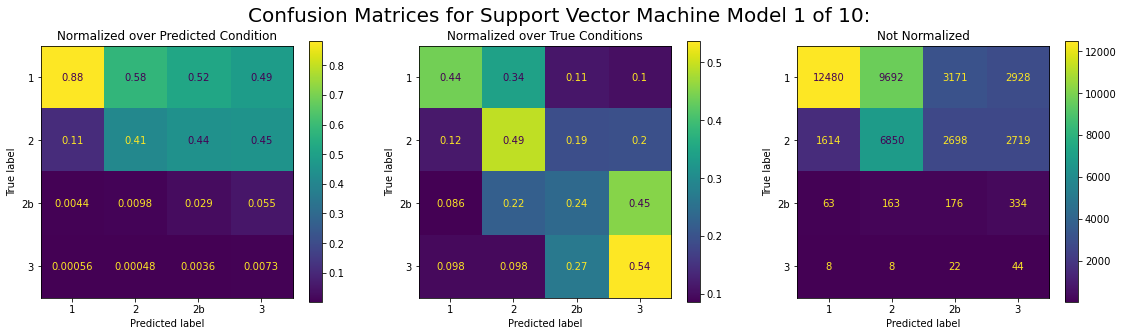

Support Vector Machine Model 2 of 10:

              precision    recall  f1-score   support

           1   0.867435  0.474019  0.613038     28271
           2   0.411987  0.486276  0.446060     13881
          2b   0.034120  0.233696  0.059546       736
           3   0.007054  0.524390  0.013920        82

    accuracy                       0.473959     42970
   macro avg   0.330149  0.429595  0.283141     42970
weighted avg   0.704392  0.473959  0.548474     42970



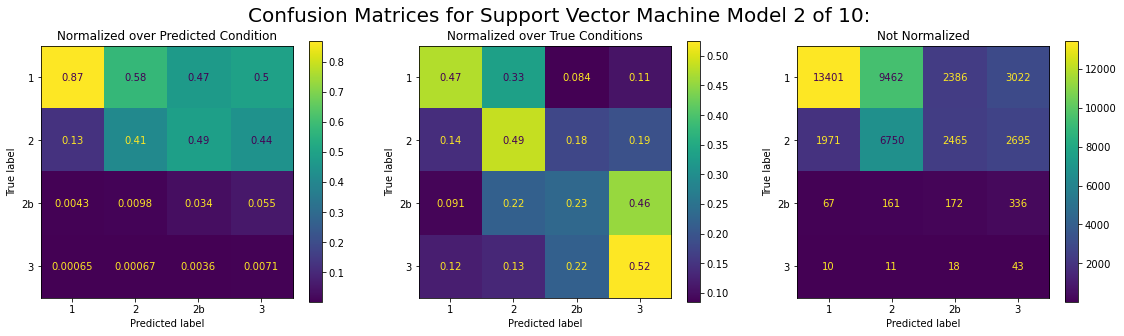

Support Vector Machine Model 3 of 10:

              precision    recall  f1-score   support

           1   0.877621  0.451523  0.596272     28271
           2   0.407891  0.499748  0.449171     13881
          2b   0.032471  0.233696  0.057020       736
           3   0.007025  0.524390  0.013864        82

    accuracy                       0.463509     42970
   macro avg   0.331252  0.427339  0.279082     42970
weighted avg   0.709743  0.463509  0.538405     42970



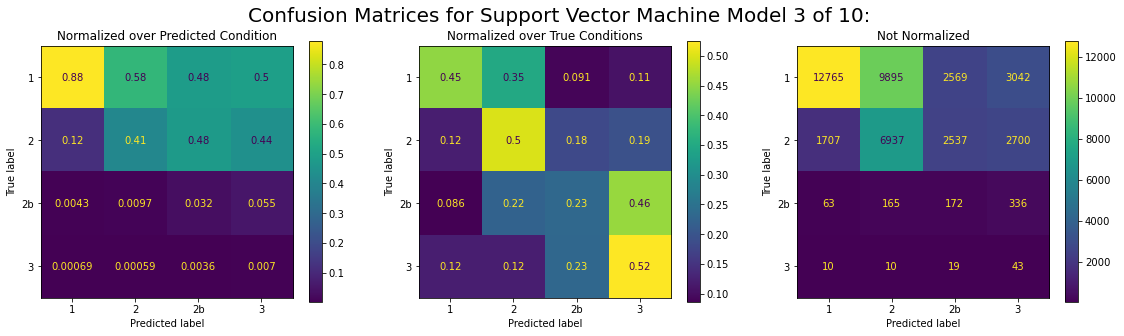

Support Vector Machine Model 4 of 10:

              precision    recall  f1-score   support

           1   0.864964  0.477839  0.615598     28271
           2   0.413084  0.481738  0.444777     13881
          2b   0.033480  0.237772  0.058695       736
           3   0.007074  0.512195  0.013956        82

    accuracy                       0.475052     42970
   macro avg   0.329650  0.427386  0.283257     42970
weighted avg   0.703110  0.475052  0.549730     42970



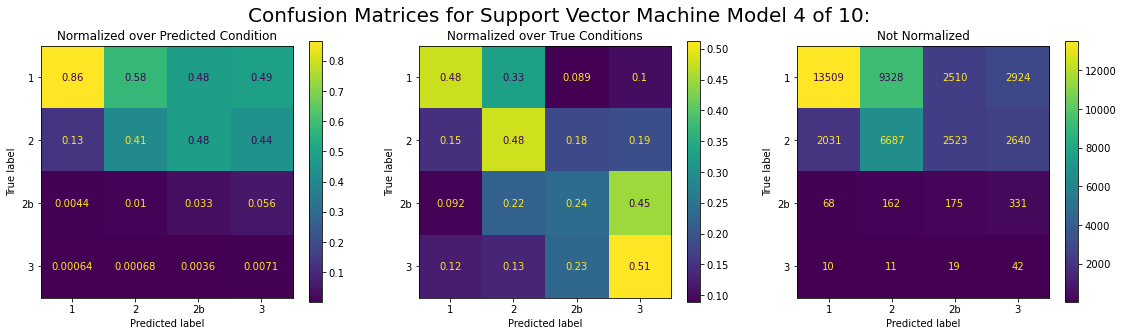

Support Vector Machine Model 5 of 10:

              precision    recall  f1-score   support

           1   0.872528  0.466556  0.608002     28271
           2   0.410327  0.491175  0.447126     13881
          2b   0.033528  0.233696  0.058643       736
           3   0.007041  0.524390  0.013896        82

    accuracy                       0.470631     42970
   macro avg   0.330856  0.428954  0.281917     42970
weighted avg   0.707197  0.470631  0.545490     42970



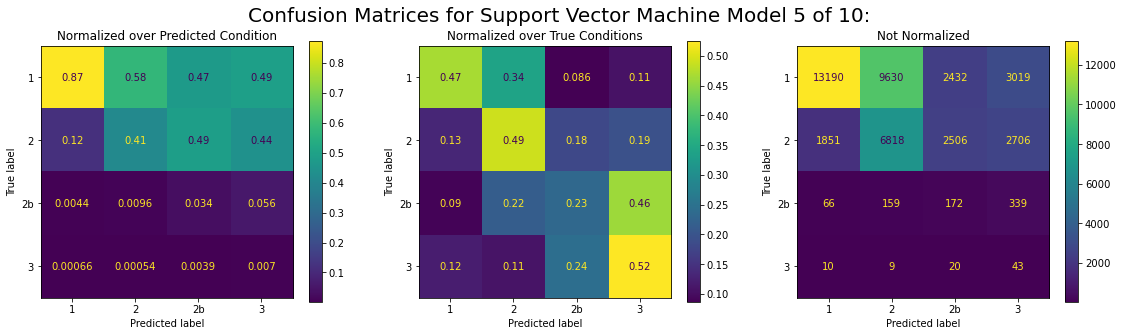

Support Vector Machine Model 6 of 10:

              precision    recall  f1-score   support

           1   0.872702  0.468501  0.609694     28271
           2   0.410734  0.496722  0.449654     13881
          2b   0.035299  0.243207  0.061650       736
           3   0.007414  0.536585  0.014625        82

    accuracy                       0.473889     42970
   macro avg   0.331537  0.436254  0.283906     42970
weighted avg   0.707474  0.473889  0.547473     42970



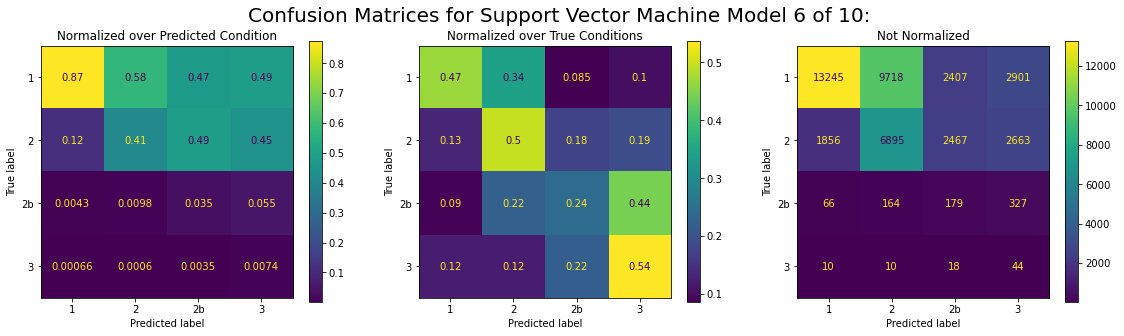

Support Vector Machine Model 7 of 10:

              precision    recall  f1-score   support

           1   0.876446  0.463691  0.606505     28271
           2   0.409735  0.500324  0.450521     13881
          2b   0.034820  0.241848  0.060876       736
           3   0.007226  0.524390  0.014255        82

    accuracy                       0.471841     42970
   macro avg   0.332057  0.432563  0.283039     42970
weighted avg   0.709605  0.471841  0.545640     42970



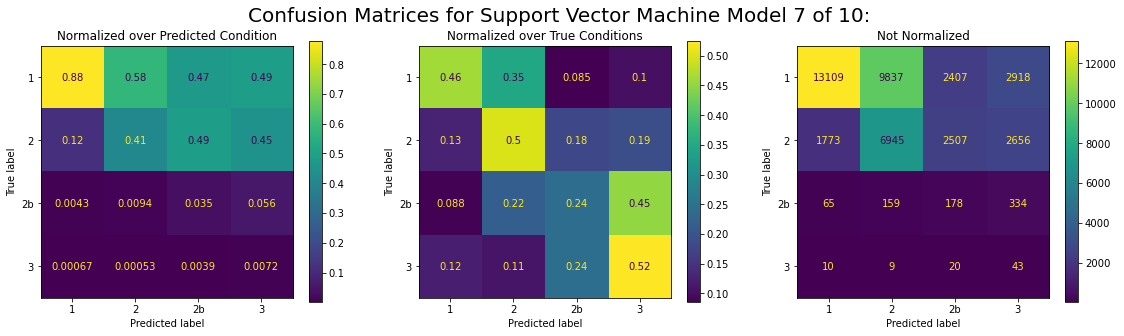

Support Vector Machine Model 8 of 10:

              precision    recall  f1-score   support

           1   0.879921  0.439602  0.586296     28271
           2   0.409260  0.490959  0.446402     13881
          2b   0.028189  0.237772  0.050403       736
           3   0.007183  0.524390  0.014173        82

    accuracy                       0.452897     42970
   macro avg   0.331138  0.423181  0.274318     42970
weighted avg   0.711625  0.452897  0.530834     42970



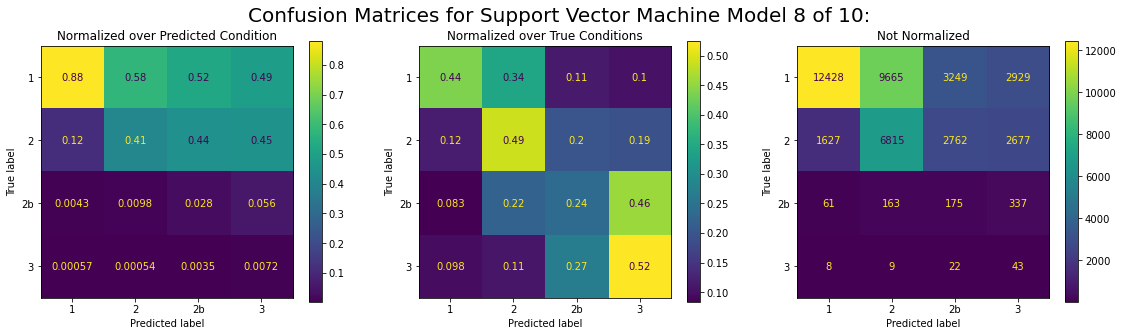

Support Vector Machine Model 9 of 10:

              precision    recall  f1-score   support

           1   0.869952  0.470871  0.611021     28271
           2   0.409593  0.489086  0.445823     13881
          2b   0.033228  0.228261  0.058011       736
           3   0.007288  0.536585  0.014381        82

    accuracy                       0.472725     42970
   macro avg   0.330015  0.431201  0.282309     42970
weighted avg   0.705260  0.472725  0.547045     42970



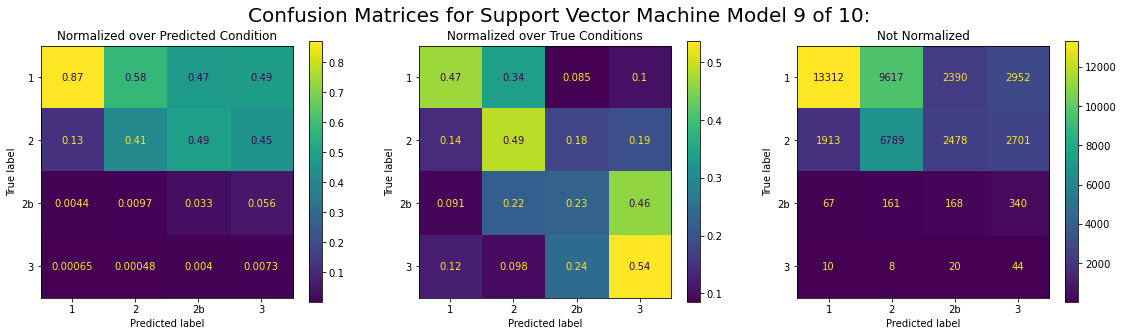

Support Vector Machine Model 10 of 10:

              precision    recall  f1-score   support

           1   0.873390  0.465318  0.607159     28271
           2   0.411839  0.491679  0.448232     13881
          2b   0.032768  0.233696  0.057477       736
           3   0.007393  0.548780  0.014589        82

    accuracy                       0.470026     42970
   macro avg   0.331348  0.434868  0.281864     42970
weighted avg   0.708240  0.470026  0.545273     42970



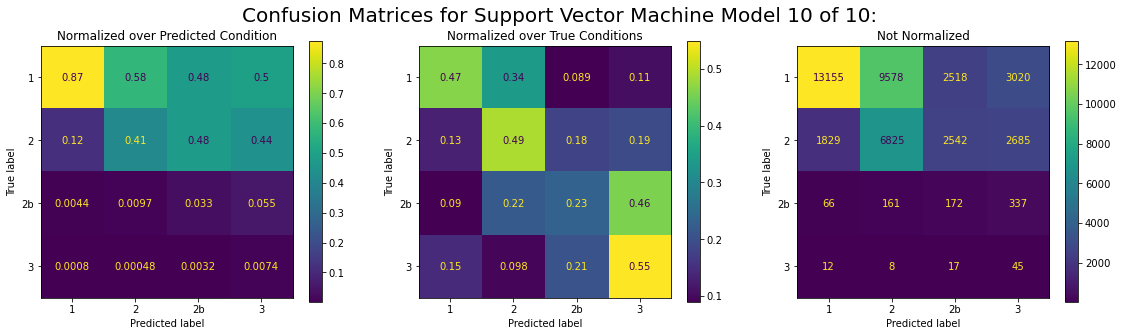

In [71]:
# For each support vector machine classifier in the cross-validation, print the score report and confusion matrices.
number_of_models = len(linear_svc_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, linear_svc_clf in zip(range(len(linear_svc_scores['estimator'])), linear_svc_scores['estimator']):
    y_test_predicted = linear_svc_clf.predict(X_test)
    print('Support Vector Machine Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Support Vector Machine Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1,3,1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1,3,2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1,3,3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)
    
    plt.show()

In [72]:
print_elapsed_time(notebook_start_time)

Elapsed time is 287.00702234508935 seconds.


In [73]:
# Report statistics of the models built for each fold of the cross-validation.
print('k-Nearest Neighbors Cross-validation Scores:')
print()
for key in sorted(k_neighbors_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(k_neighbors_scores[key]), np.std(k_neighbors_scores[key])), sep='')
        print('%s :%s' % (key, k_neighbors_scores[key]), sep='')
        print()

k-Nearest Neighbors Cross-validation Scores:

fit_time: mean = 0.022367, std = 0.007204
fit_time :[0.0252955  0.02214098 0.02078962 0.02380776 0.01655149 0.02235508
 0.04188418 0.01765561 0.01555157 0.01764131]

score_time: mean = 0.269804, std = 0.035765
score_time :[0.25470996 0.24725509 0.24917912 0.27865934 0.2866776  0.36910796
 0.25183868 0.26208735 0.25871706 0.23980808]

test_f1_macro: mean = 0.472184, std = 0.029162
test_f1_macro :[0.5110816  0.46463522 0.46994144 0.40533565 0.48044083 0.46348139
 0.46830154 0.46165161 0.47840351 0.51856956]

test_f1_weighted: mean = 0.472184, std = 0.029029
test_f1_weighted :[0.51078986 0.46390103 0.4707665  0.40596803 0.48084031 0.46351137
 0.46802912 0.4610586  0.47840351 0.51856956]

test_neg_log_loss: mean = -3.129086, std = 0.592788
test_neg_log_loss :[-2.99783529 -3.8761988  -3.93084299 -3.14684811 -3.0247048  -2.89675446
 -2.40655342 -2.52867157 -4.05451025 -2.42793818]

test_precision_macro: mean = 0.480555, std = 0.029158
test_precis

k-Nearest Neighbor Model 1 of 10:

              precision    recall  f1-score   support

           1   0.801381  0.550175  0.652433     28271
           2   0.397851  0.410777  0.404211     13881
          2b   0.038245  0.248641  0.066292       736
           3   0.008101  0.439024  0.015908        82

    accuracy                       0.499767     42970
   macro avg   0.311394  0.412155  0.284711     42970
weighted avg   0.656440  0.499767  0.560993     42970



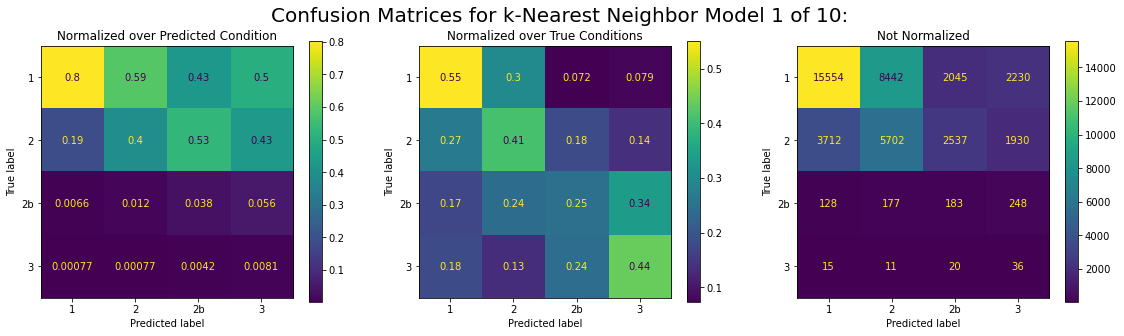

k-Nearest Neighbor Model 2 of 10:

              precision    recall  f1-score   support

           1   0.807796  0.559266  0.660940     28271
           2   0.402473  0.410273  0.406336     13881
          2b   0.039707  0.250000  0.068529       736
           3   0.008454  0.475610  0.016613        82

    accuracy                       0.505678     42970
   macro avg   0.314608  0.423787  0.288104     42970
weighted avg   0.662180  0.505678  0.567316     42970



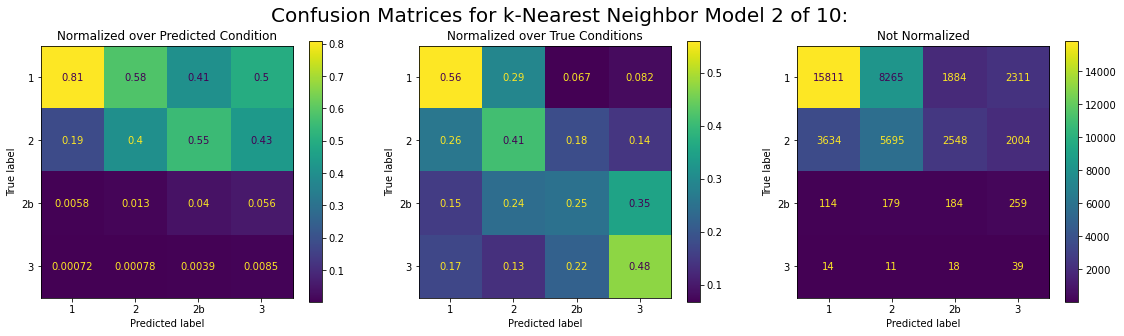

k-Nearest Neighbor Model 3 of 10:

              precision    recall  f1-score   support

           1   0.826057  0.510665  0.631153     28271
           2   0.401094  0.464808  0.430607     13881
          2b   0.038421  0.250000  0.066606       736
           3   0.008229  0.463415  0.016170        82

    accuracy                       0.491296     42970
   macro avg   0.318450  0.422222  0.286134     42970
weighted avg   0.673726  0.491296  0.555526     42970



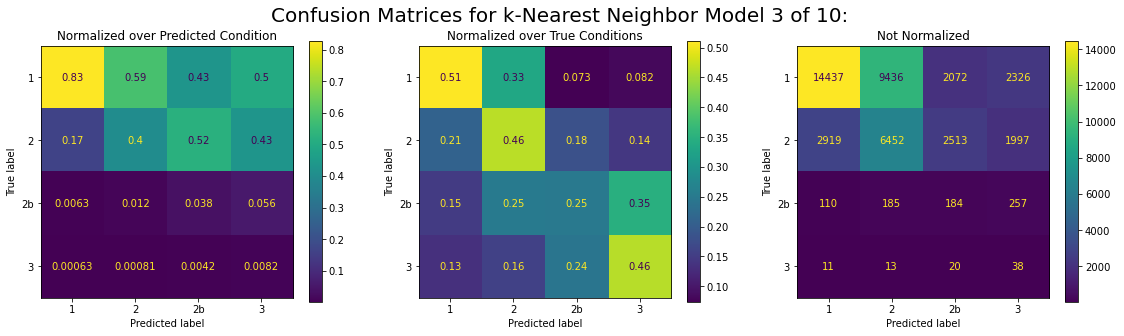

k-Nearest Neighbor Model 4 of 10:

              precision    recall  f1-score   support

           1   0.831009  0.512080  0.633678     28271
           2   0.408089  0.461566  0.433183     13881
          2b   0.040346  0.247283  0.069373       736
           3   0.007306  0.475610  0.014391        82

    accuracy                       0.491157     42970
   macro avg   0.321687  0.424135  0.287656     42970
weighted avg   0.679274  0.491157  0.558063     42970



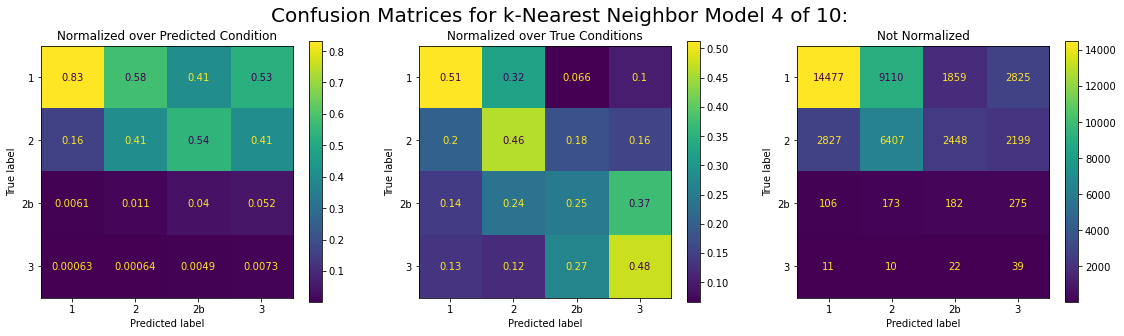

k-Nearest Neighbor Model 5 of 10:

              precision    recall  f1-score   support

           1   0.829622  0.516536  0.636671     28271
           2   0.401587  0.484907  0.439332     13881
          2b   0.040406  0.226902  0.068597       736
           3   0.008270  0.451220  0.016242        82

    accuracy                       0.501233     42970
   macro avg   0.319971  0.419891  0.290211     42970
weighted avg   0.676264  0.501233  0.562008     42970



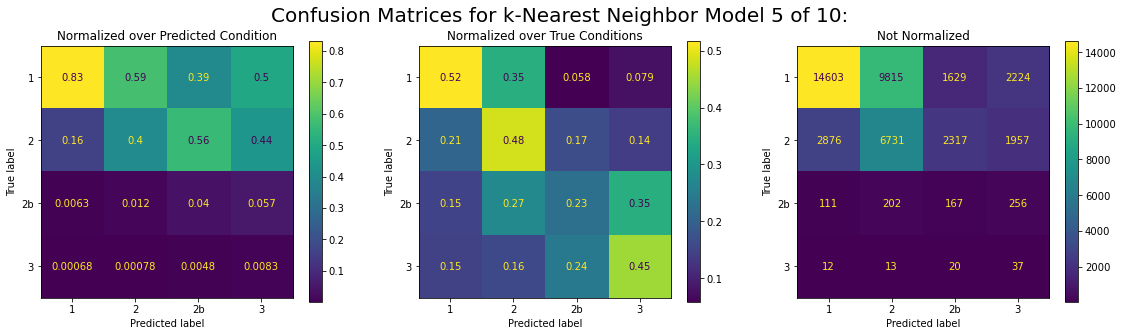

k-Nearest Neighbor Model 6 of 10:

              precision    recall  f1-score   support

           1   0.836590  0.508861  0.632811     28271
           2   0.404030  0.492544  0.443918     13881
          2b   0.036639  0.213315  0.062537       736
           3   0.008321  0.463415  0.016348        82

    accuracy                       0.498441     42970
   macro avg   0.321395  0.419534  0.288903     42970
weighted avg   0.681574  0.498441  0.560847     42970



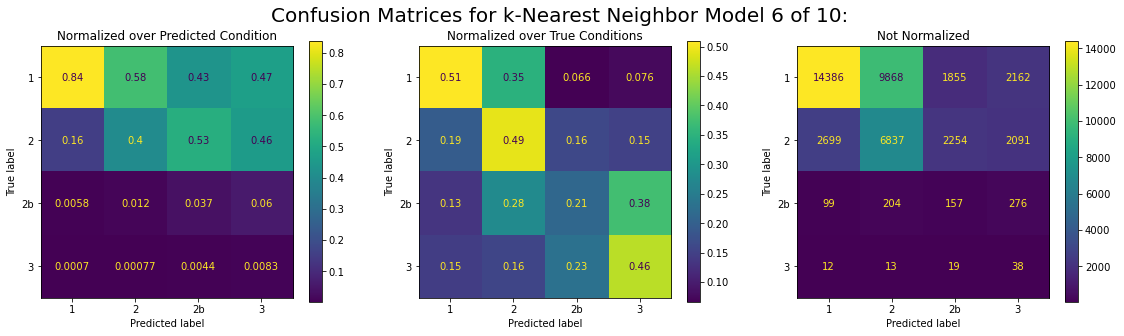

k-Nearest Neighbor Model 7 of 10:

              precision    recall  f1-score   support

           1   0.838413  0.486541  0.615753     28271
           2   0.411236  0.467762  0.437681     13881
          2b   0.033236  0.247283  0.058596       736
           3   0.007737  0.500000  0.015239        82

    accuracy                       0.476402     42970
   macro avg   0.322655  0.425396  0.281817     42970
weighted avg   0.685041  0.476402  0.547540     42970



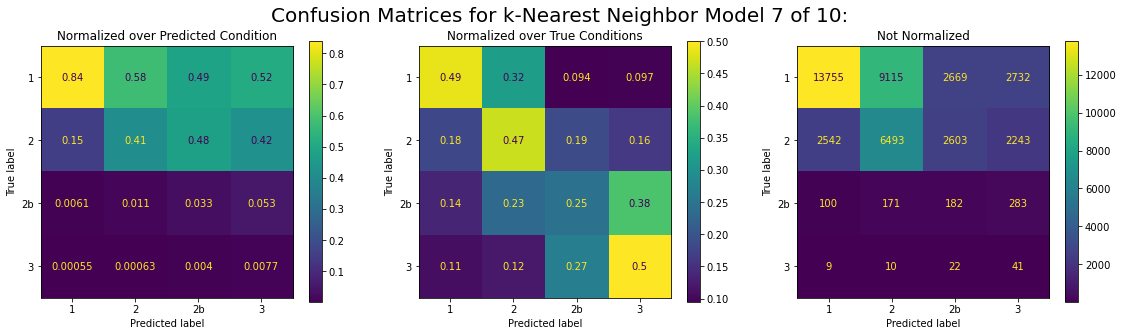

k-Nearest Neighbor Model 8 of 10:

              precision    recall  f1-score   support

           1   0.840889  0.478936  0.610281     28271
           2   0.404303  0.467041  0.433414     13881
          2b   0.029651  0.232337  0.052591       736
           3   0.008093  0.500000  0.015929        82

    accuracy                       0.470910     42970
   macro avg   0.320734  0.419579  0.278054     42970
weighted avg   0.684371  0.470910  0.542459     42970



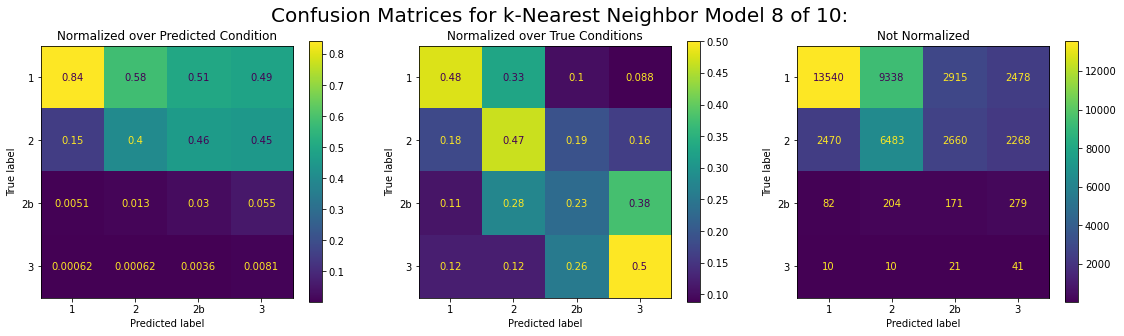

k-Nearest Neighbor Model 9 of 10:

              precision    recall  f1-score   support

           1   0.834140  0.518199  0.639263     28271
           2   0.407883  0.474173  0.438537     13881
          2b   0.038470  0.236413  0.066172       736
           3   0.007794  0.451220  0.015324        82

    accuracy                       0.499023     42970
   macro avg   0.322072  0.420001  0.289824     42970
weighted avg   0.681237  0.499023  0.563414     42970



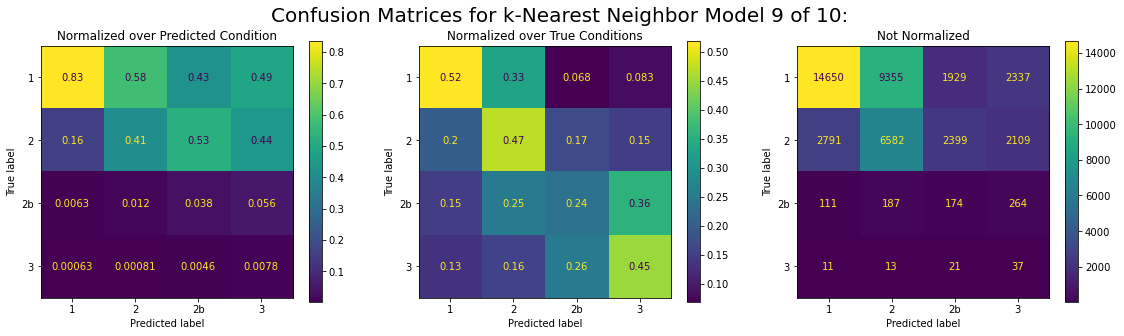

k-Nearest Neighbor Model 10 of 10:

              precision    recall  f1-score   support

           1   0.837707  0.508118  0.632555     28271
           2   0.404924  0.479865  0.439221     13881
          2b   0.039883  0.259511  0.069140       736
           3   0.008510  0.475610  0.016720        82

    accuracy                       0.494671     42970
   macro avg   0.322756  0.430776  0.289409     42970
weighted avg   0.682653  0.494671  0.559275     42970



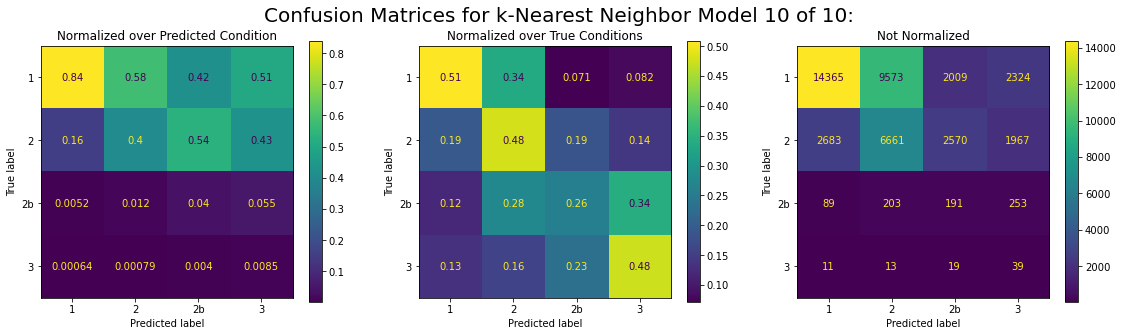

In [74]:
# For each k-Nearest Neighbor classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(k_neighbors_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, knn_clf in zip(range(len(k_neighbors_scores['estimator'])), k_neighbors_scores['estimator']):
    y_test_predicted = knn_clf.predict(X_test)
    print('k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [75]:
print('All reports and graphics generated in %f seconds.' % (elapsed_time(t0)))

All reports and graphics generated in 833.135919 seconds.


In [76]:
print_elapsed_time(notebook_start_time)

Elapsed time is 951.3657447680598 seconds.
